In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import numpy as np
from tensorflow import keras
import matplotlib.dates as mdates
import datetime
import typhon as ty
import src
import nn_iwp_retrieval

plt.style.use(ty.plots.styles.get('typhon'))

### Reading in HAMP radar and radiometer data

In [6]:
# Select which HALO research flight to plot
# and get corresponding date of flight
RF_NR = 'RF05'
DATE = src.get_RF_date_of(RF_NR)
MONTH = DATE[4:6]
DAY = DATE[6:9]

# indicate which timeslot of flight should be plotted
# if nothing indicated (''), the whole flight will be plotted
TIMESLOT = ''

if TIMESLOT != '': # display time segment of RF
    # convert timeslot string (of flight segment) to datetime format for data slicing
    start_segment = datetime.datetime(
        int(DATE[0:4]),int(DATE[5:6]),int(DATE[6:8]), 
        int(TIMESLOT[0:2]),int(TIMESLOT[2:4]), 0)
    end_segment = datetime.datetime(
        int(DATE[0:4]),int(DATE[5:6]),int(DATE[6:8]), 
        int(TIMESLOT[5:7]),int(TIMESLOT[7:9]), 0)

# paths to HAMP radar and radiometer data (change to your local folder)
# note: Use offset corrected radiometer data if existing
PATH_RADAR = f'/Users/maxringel/Documents/Studium/Studium_MSc/master_thesis/data/HALO-AC3/HALO/hamp_mira/HALO-AC3_HALO_hamp_radar_{DATE}_{RF_NR}.nc'
PATH_RADIOMETER = '/Users/maxringel/Documents/Studium/Studium_MSc/master_thesis/code/Code_levante_backup/HAMP_corr'
    
if TIMESLOT == '': # display full RF
    radar = xr.open_dataset(PATH_RADAR)
    radiometer, sfc_mask = src.load_all_hamp_obs(
        path=PATH_RADIOMETER,
        freqs='NN_freqs',sfc_type='ocean')
    radiometer = radiometer.sel(time=f'2022-{MONTH}-{DAY}')
    sfc_mask = sfc_mask.sel(time=f'2022-{MONTH}-{DAY}')
    
if TIMESLOT != '': # display time segment of RF
    radar = xr.open_dataset(PATH_RADAR)
    radiometer, sfc_mask = src.load_all_hamp_obs(
        path=PATH_RADIOMETER,
        freqs='NN_freqs',sfc_type='ocean')
    radiometer = radiometer.sel(time=slice(start_segment,end_segment))
    sfc_mask = sfc_mask.sel(time=slice(start_segment,end_segment))

HAMP_TBs = radiometer.TB_corr.values
HAMP_alt = radiometer.alt.values

print(f'{len(HAMP_TBs)} HAMP TBs at {(len(HAMP_TBs[0,:]))} frequencies in total')

print("")
print("Masking TBs measured 2.5mins before and after sea-ice contamination...")
HAMP_TBs = src.mask_seaice_edges(HAMP_TBs, sfc_mask, timerange=150)


31310 HAMP TBs at 24 frequencies in total

Masking TBs measured 2.5mins before and after sea-ice contamination...


### Retrieving the IWP from HAMP brightness temperatures

In [7]:
iwp,levels = nn_iwp_retrieval.retrieve_IWP(HAMP_TBs,HAMP_alt)


Retrieving IWP from HAMP TBs...

Retrieving from 13000m (9438 TBs)
Retrieving from 12500m (8952 TBs)
Retrieving from 12000m (4935 TBs)
Retrieving from 11500m (36 TBs)
Retrieving from 11000m (42 TBs)
Retrieving from 10500m (12 TBs)
Retrieving from 9500m (23 TBs)
Retrieving from 9000m (35 TBs)
Retrieving from 8500m (7837 TBs)

0.0 % negative predictions (=clipped to 0).



/Users/maxringel/Documents/Studium/Studium_MSc/master_thesis/NN_IWP_retrieval/nn_iwp_retrieval.py:177: RuntimeWarning: Mean of empty slice
  IWP = np.nanmean(np.array([IWP_V1,IWP_V2,IWP_V3]),axis=0)


### Plotting the retrieved IWP along with HAMP observations

/var/folders/8v/cgglfx6x1ksbg8s4nj11htx80000gn/T/ipykernel_15887/441367211.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frequencies = np.array([
/opt/anaconda3/envs/ac3env/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


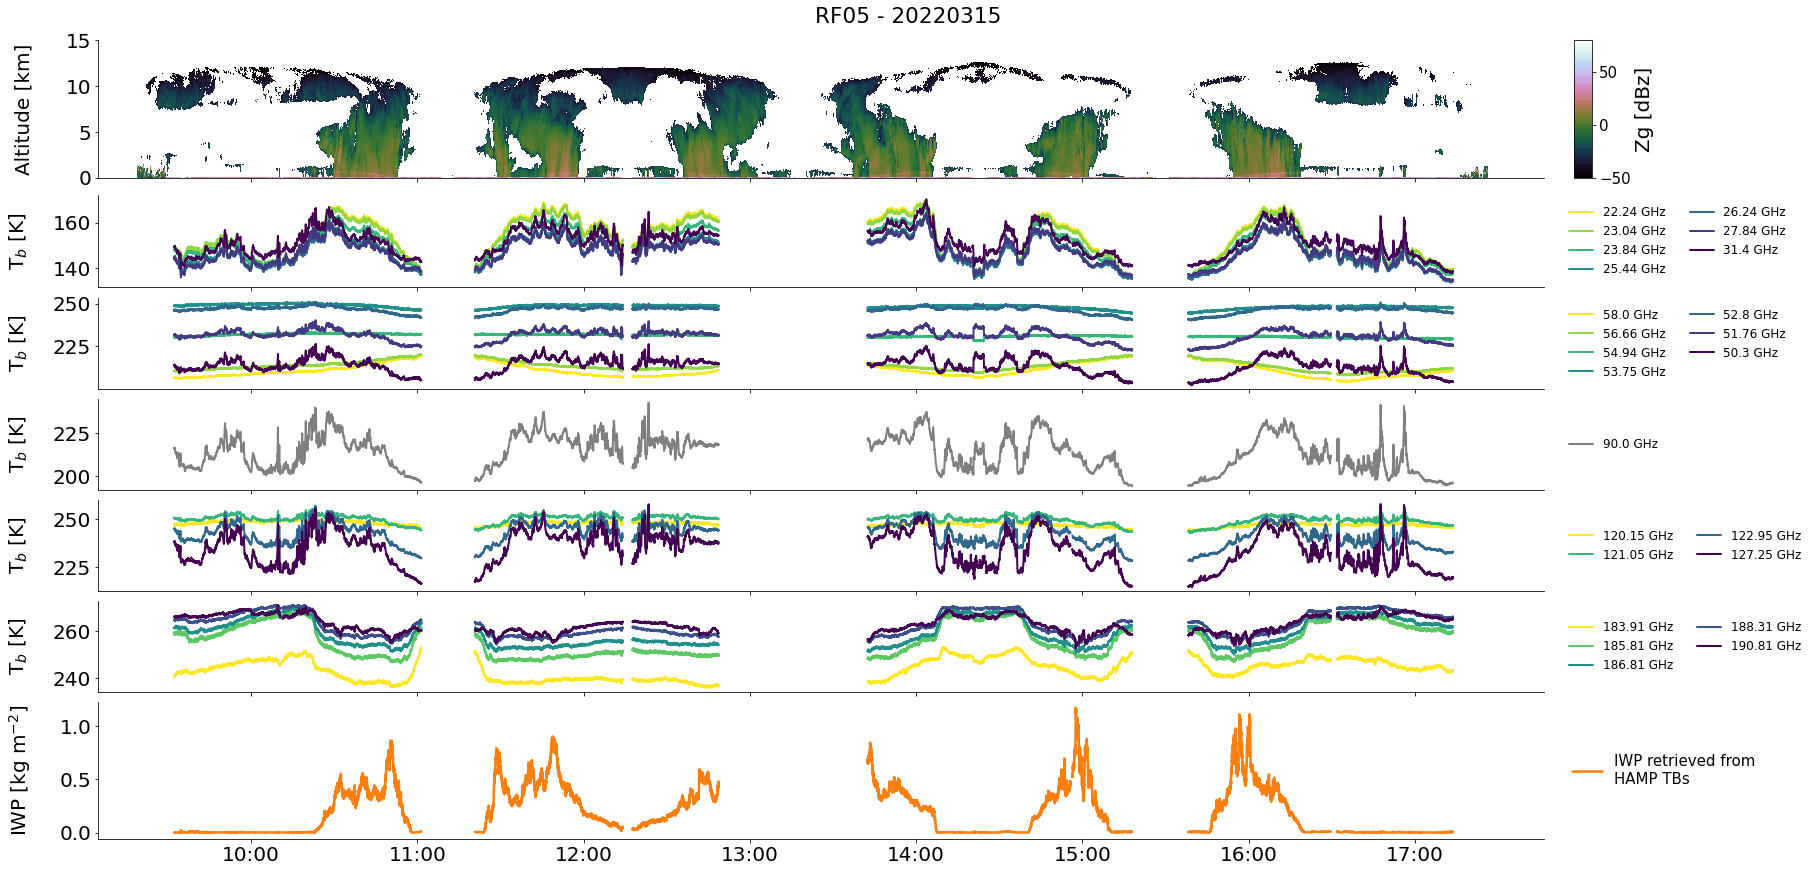

In [10]:
fig, axs = plt.subplots(nrows=7,ncols=1,
                        sharex=True,
                        figsize=(25,12),
                        gridspec_kw={'height_ratios': [1.5,1,1,1,1,1,1.5]},
                        constrained_layout=True)

fig.suptitle(f'{RF_NR} - {DATE}')

# set some global plot style settings
kwargs = dict(linewidth=2)
grid_alpha = 0.5
legend_fontsize = 12
y_axis_fontsize = 14
min_alt, max_alt = 0,15

# define array of frequenices to plot
frequencies = np.array([
    src.get_HAMP_freqs_of('K_band'),
    np.flip(src.get_HAMP_freqs_of('V_band')),
    src.get_HAMP_freqs_of('W_band'),
    src.get_HAMP_freqs_of('F_band_1side'),
    np.delete(src.get_HAMP_freqs_of('G_band_1side'),[1,-1]),])

# settings of the frequency legend
props = dict(boxstyle='round', facecolor='white', alpha=1.)

# Plot radar reflectivities (Zg)
im = axs[0].pcolormesh(
    radar.time, radar.height/1000, 10*np.log10(radar.Zg.T), 
    vmin=-50, vmax=80, cmap='cubehelix', shading='nearest')
axs[0].set_ylim(min_alt,max_alt)
axs[0].set_ylabel('Altitude [km]',fontsize=20)
axs[0].yaxis.set_label_coords(-0.045,.5)
axs[0].tick_params(axis='y', labelsize=20)
cbar = fig.colorbar(im, ax=axs[0], pad=-0.16,aspect=7.5)
cbar.set_label('Zg [dBz]',size=20)
cbar.ax.tick_params(labelsize=15)

# Plot radiometer measurements (TBs)
row = 1
panel_labels =['b)','c)','d)','e)','f)']
for module in range(len(frequencies)):
    
    freq_ind = [np.where(src.get_HAMP_freqs_of('NN_freqs')==freq)[0][0] for freq in frequencies[module]]
    
    colors = cm.get_cmap('viridis_r', len(frequencies[module])).colors  
    if module == 2:
        colors = ['grey']
    for i in range(len(frequencies[module])):
        axs[row].plot(radiometer.time.values,HAMP_TBs[:,freq_ind[i]],
                     zorder=i,
                     color=colors[i],
                     label=str(frequencies[module][i])+' GHz',
                     **kwargs)

    axs[row].set_ylabel('T$_b$ [K]',fontsize=20)
    axs[row].yaxis.set_ticks_position('left')
    axs[row].yaxis.set_label_coords(-0.047,.5)
    axs[row].tick_params(axis='y', labelsize=20)
    axs[row].legend(frameon=False, 
                   bbox_to_anchor=(1.01, 0.5), 
                   loc='center left', 
                   ncol=2, 
                   fontsize=legend_fontsize)

    row+=1

# Plot IWP retrieved from HAMP TBs 
axs[6].plot(radiometer.time.values,iwp/1000,color='C1',linewidth=2.5,label='IWP retrieved from \nHAMP TBs')
axs[6].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs[6].tick_params(axis='x', labelsize=20)
axs[6].tick_params(axis='y', labelsize=20)
axs[6].set_ylabel('IWP [kg m$^{-2}$]',color='black',fontsize=20)
axs[6].yaxis.set_label_coords(-0.045,.5)
axs[6].legend(frameon=False, 
              bbox_to_anchor=(1.01, 0.5), 
              loc='center left',
              fontsize=15)